In [2]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns

indir1 = '/home/hsher/scratch/circ_nextera_iter13/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

# indir2 = '/home/hsher/scratch/circ_nextera_iter7/output/'
# circ_quant_output += [os.path.join(indir2,f) for f in os.listdir(indir2) if f.endswith('.gtf')]


In [ ]:
circ_quant_output

In [3]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [4]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
for fname in circ_quant_output:
    name = os.path.basename(fname).replace('.gtf', '')
    names.append(name)
    
    circ_df, stat = read_ciri_gtf(fname)
    
    circ_type_count.append(circ_df['circ_type'].value_counts())
    
    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))

In [5]:
stats_df = pd.concat(stats, axis = 1).T

In [6]:
stats_df.columns

Index(['##Sample', '##Total_Reads', '##Mapped_Reads', '##Circular_Reads',
       '##version'],
      dtype='object', name=0)

In [7]:
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

In [8]:
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']

In [9]:
stats_df.sort_values('frac_circular')
stats_df.set_index('##Sample', inplace = True)

In [10]:
stats_df

,##Total_Reads,##Mapped_Reads,##Circular_Reads,##version,frac_circular,frac_mapped
##Sample,,,,,,
HEK_JC_rar11,350774034,282857676,5851662,1.1.2,0.020688,0.806381
Exo05,116448244,15410366,3004,1.1.2,0.000195,0.132337
HEK_rar11,288352678,238307158,5730810,1.1.2,0.024048,0.826443
EV_rar11,304642022,190824576,4761304,1.1.2,0.024951,0.626390
TOB2_rar11,228398110,183221060,3887038,1.1.2,0.021215,0.802200
Exo10,127456780,20087518,4028,1.1.2,0.000201,0.157603
EV_rz,73924826,65059368,27220,1.1.2,0.000418,0.880075
HEK_rar,53364598,44398808,394084,1.1.2,0.008876,0.831990
TOB2_rz,61071552,55602434,24558,1.1.2,0.000442,0.910447


In [11]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [12]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [13]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [14]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

Text(0.5, 0, '# circRNA detected')

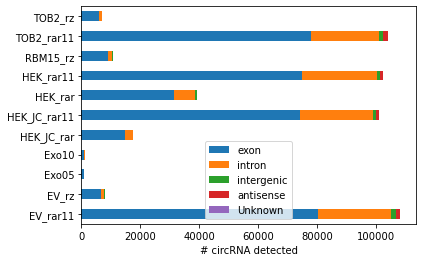

In [16]:
import matplotlib.pyplot as plt
counts.T.sort_index().plot.barh(stacked = True)
plt.xlabel('# circRNA detected')

In [ ]:
bsj.reindex(sorted(bsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting circRNA (bsj reads)')
sns.despine()

In [ ]:
fsj.reindex(sorted(fsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting normal splicing (fsj reads)')
sns.despine()

In [ ]:
((bsj.fillna(0)+1)/(fsj.fillna(0)+1)).boxplot(showfliers=False, rot = 90)
plt.ylabel('(BSJ+1)/(FSJ+1)')

In [ ]:
from pathlib import Path
indir = Path('/home/hsher/scratch/circ_nextera/')
indir2 = Path('/home/hsher/scratch/circ_truseq/')
star_log1 = pd.read_csv(indir/'QC/genome_mapping_stats.csv')
star_log2 = pd.read_csv(indir2/'QC/genome_mapping_stats.csv')
star_log = pd.concat([star_log1, star_log2], axis = 0)
star_log.index = star_log['STAR Log filename'].apply(lambda x: x.split('/')[-1].replace('.Log.final.out',''))
star_log.sort_index(inplace = True)

In [ ]:
stats_df['frac_circular'].plot.barh(color = ['tomato' if 'rar' in index else 'royalblue' for index in star_log.index])
plt.xlabel('fraction circular RNA reads')

In [ ]:
total_stat = pd.concat([stats_df,star_log], axis = 1)

In [ ]:
total_stat

In [ ]:
# let's find mapped to ribosomal RNA
gencode_coords[0].attrs

In [ ]:
from pybedtools import BedTool
gencode_coords = BedTool('/home/hsher/gencode_coords/gencode.v35.basic.annotation.gff3')
rRNA_regions = gencode_coords.filter(lambda region: region[2]=='gene' and 'rRNA' in region.attrs['gene_type']).saveas()

In [ ]:
len(rRNA_regions)

In [ ]:
len(rRNA_regions.merge(s = True)) # make sure no overlap

In [ ]:
genome_align_ciri_bams = list((indir / 'output'/'align').glob('*.bam'))
genome_align_ciri_bams += list((indir2 / 'output'/'align').glob('*.bam'))


In [ ]:
genome_align_ciri_bams = [str(f) for f in genome_align_ciri_bams]

In [ ]:
rRNA_cov = rRNA_regions.multicov(bams = genome_align_ciri_bams, s = True) # strandedness = True, proper pair = True

In [ ]:
libnames = [os.path.basename(f).split('.')[0] for f in genome_align_ciri_bams]
rRNA_cov_df = rRNA_cov.to_dataframe(names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attributes']+
                                   libnames)

In [ ]:
rRNA_cov_df.head()

In [ ]:
rRNA_cov_df[libnames].sum()

In [ ]:
import pysam
pysam.AlignmentFile(genome_align_ciri_bams[0]).mapped

In [ ]:
genome_mapped = [pysam.AlignmentFile(f).mapped for f in genome_align_ciri_bams]

In [ ]:
dict(zip(libnames, genome_mapped))

In [ ]:
total_stat['genome_mapped_HISAT']=total_stat.index.map(dict(zip(libnames, genome_mapped))).tolist()

In [ ]:
total_stat.plot.scatter(x = '##Mapped_Reads', y = 'genome_mapped_HISAT')

In [ ]:
total_stat['genome_mapped_HISAT']

In [ ]:
total_stat[['Number of reads mapped to too many loci','##Mapped_Reads','##Circular_Reads']]

In [ ]:
(total_stat['Number of reads mapped to too many loci']/total_stat['##Mapped_Reads']).plot.barh(
color = ['tomato' if 'rar' in index else 'royalblue' for index in star_log.index])

plt.xlabel('STAR multimap / HISAT mapped')

In [ ]:
(total_stat['##Circular_Reads']/(total_stat['##Mapped_Reads']-total_stat['Number of reads mapped to too many loci'])).plot.barh(
color = ['tomato' if 'rar' in index else 'royalblue' for index in star_log.index])

plt.xlabel('estimated of circRNA fraction post Jumpcode removal')

In [ ]:
(rRNA_cov_df[libnames].sum()/total_stat['genome_mapped_HISAT']).plot.barh(color = ['tomato' if 'rar' in index else 'royalblue' for index in star_log.index])
plt.xlabel('% aligning to rRNA based on HISAT alignment')

In [ ]:
rRNA_cov_df[['gene_type', 'gene_name']]=rRNA_cov_df['attributes'].str.split(';', expand = True)[[2,3]]

In [ ]:
rRNA_cov_df.groupby('gene_type')[libnames].sum()

In [ ]:
rRNA_cov_df.loc[rRNA_cov_df['gene_type']=='gene_type=rRNA']

In [ ]:
rRNA_cov_df.loc[rRNA_cov_df['gene_name'].str.contains('5S')]

In [ ]:
rRNA_cov_df['gene_name'].str.replace('gene_name=', '').unique()

In [ ]:
rRNA_cov_df['gene_name']

In [ ]:
total_stat.plot.scatter(x = '##Mapped_Reads', y = 'Uniquely mapped reads number')